# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# !conda install -y tqdm pillow matplotlib

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

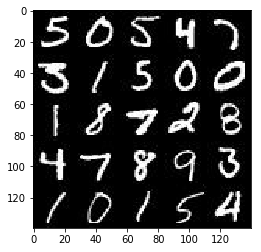

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

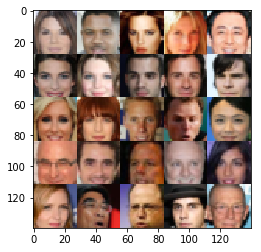

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    image_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='image_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return image_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    kernel_size = 5
    with tf.variable_scope('discriminator', reuse=reuse):

        # (28, 82, 3) -> (14,14, 128) -> (7, 7, 256) -> Flatten -> FC
        
        # input: (None, 28, 28, 3) 
        x = images

        # Conv2D(stride=2) -> output: (None, 14, 14, 128),  note: we don't use BatchNorm for the 1st layer
        x = tf.layers.conv2d(x, 128, kernel_size, strides=2, padding='same')
        x = tf.maximum(alpha*x, x)
        x = tf.contrib.layers.dropout(x, keep_prob=0.5)

        # Conv2D(stride=2) -> output(None, 7, 7, 256)
        x = tf.layers.conv2d(x, 256, kernel_size, strides=2, padding='same')
        x = tf.layers.batch_normalization(x)
        x = tf.maximum(alpha*x, x)
        x = tf.contrib.layers.dropout(x, keep_prob=0.5)

        # Flatten
        x = tf.reshape(x, (-1, 7 * 7 * 256))
        
        # FC/Logits
        logits = tf.layers.dense(x, 1, activation=None)

        # Sigmoid
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    kernel_size = 5
    
    # When training, we want reuse the vars, but 
    with tf.variable_scope('generator', reuse=(not is_train)):

        # FC -> Reshape_to_Cube -> Conv2D_T -> Conv2D_T -> Tanh
        
        # FC /wo activation
        x = z
        #x = tf.layers.dense(x, 7*7*256, activation=None)
        x = tf.layers.dense(x, 7*7*512, activation=None)
        
        # Reshape to the cube
        #x = tf.reshape(x, (-1, 7, 7, 256)) 
        x = tf.reshape(x, (-1, 7, 7, 512)) 
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        
        # Conv2D_T -> (None, 14, 14, 128)
        #x = tf.layers.conv2d_transpose(x, 128, kernel_size, strides=2, padding='same', activation=None)
        x = tf.layers.conv2d_transpose(x, 64, kernel_size, strides=2, padding='same', activation=None)
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        
        # Conv2D_T -> (None, 28, 28, out_channel_dim=1 or 3)
        x = tf.layers.conv2d_transpose(x, out_channel_dim, kernel_size, strides=2, padding='same', activation=None)
        #x = tf.layers.batch_normalization(x, training=is_train)
        #x = tf.maximum(alpha*x, x)
    
        # Tanh
        output = tf.tanh(x)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    sigmoid_ce_with_logits = tf.nn.sigmoid_cross_entropy_with_logits

    # Label smoothing for Discriminator
    # - https://github.com/soumith/ganhacks
    # - https://arxiv.org/pdf/1606.03498.pdf
    d_loss_real = tf.reduce_mean(sigmoid_ce_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    #d_loss_fake = tf.reduce_mean(sigmoid_ce_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss_fake = tf.reduce_mean(sigmoid_ce_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake) * 0.1))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(sigmoid_ce_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode, alpha=0.1):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False, alpha),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha=0.1, n_show_status=25):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_examples, image_width, image_height, image_channels = data_shape # data_shape=(n_batches, w, h, ch)
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    print('input data_shape: ', data_shape)
    print('input_real: {}, input_z: {}, lr: {}'.format(input_real.get_shape(), input_z.get_shape(), learning_rate))

    d_loss, g_loss = model_loss(input_real, input_z, image_channels, alpha)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    batch_step = 0
    show_status_step = (epoch_count * n_examples) // (batch_size * n_show_status) # 25 times
    show_image_step  = (epoch_count * n_examples) // (batch_size * (n_show_status // 5))  # 5 times
    print('show status on every {} batches, image on every {} batches'.format(show_status_step, show_image_step))
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            
            # batch_images: (None, W, H, Ch)
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                batch_step += 1
                
                # As Generator output is -1.0~1.0, amplify real image to -1.0~1.0 (as they were -0.5 to 0.5)
                batch_images *= 2.0

                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers 
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, lr: learning_rate}) 

                # Show training status and images
                if batch_step % show_status_step == 0:
                    # Train status
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z })
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}, Batch Step:{}, Proc Imgs: {}k ...".format(epoch_i+1, epoch_count, batch_step, batch_step*batch_size//1000),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if batch_step % show_image_step == 0:
                    show_generator_output(sess, 5**2, input_z, image_channels, data_image_mode)

        # last
        show_generator_output(sess, 5**2, input_z, image_channels, data_image_mode)

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

# LReLU alpha=0.1, Generator (filters 512 -> 64, original was: 256 -> 128)
----

input data_shape:  (60000, 28, 28, 1)
input_real: (?, 28, 28, 1), input_z: (?, 100), lr: 0.0002
show status on every 240 batches, image on every 1200 batches
Epoch 1/2, Batch Step:240, Proc Imgs: 4k ... Discriminator Loss: 1.3683... Generator Loss: 0.6644
Epoch 1/2, Batch Step:480, Proc Imgs: 9k ... Discriminator Loss: 1.3560... Generator Loss: 0.6394
Epoch 1/2, Batch Step:720, Proc Imgs: 14k ... Discriminator Loss: 1.2985... Generator Loss: 0.6299
Epoch 1/2, Batch Step:960, Proc Imgs: 19k ... Discriminator Loss: 1.3380... Generator Loss: 0.7422
Epoch 1/2, Batch Step:1200, Proc Imgs: 24k ... Discriminator Loss: 1.2805... Generator Loss: 0.7608


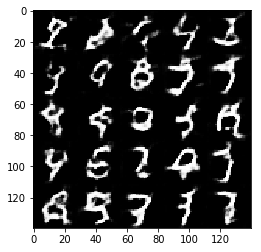

Epoch 1/2, Batch Step:1440, Proc Imgs: 28k ... Discriminator Loss: 1.3325... Generator Loss: 0.9582
Epoch 1/2, Batch Step:1680, Proc Imgs: 33k ... Discriminator Loss: 1.4191... Generator Loss: 0.7112
Epoch 1/2, Batch Step:1920, Proc Imgs: 38k ... Discriminator Loss: 1.3874... Generator Loss: 0.6136
Epoch 1/2, Batch Step:2160, Proc Imgs: 43k ... Discriminator Loss: 1.3960... Generator Loss: 0.7293
Epoch 1/2, Batch Step:2400, Proc Imgs: 48k ... Discriminator Loss: 1.3495... Generator Loss: 0.7049


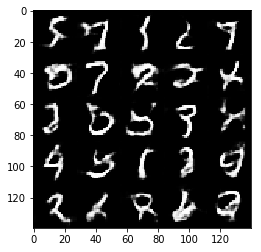

Epoch 1/2, Batch Step:2640, Proc Imgs: 52k ... Discriminator Loss: 1.3936... Generator Loss: 0.7423
Epoch 1/2, Batch Step:2880, Proc Imgs: 57k ... Discriminator Loss: 1.3548... Generator Loss: 0.7357
Epoch 2/2, Batch Step:3120, Proc Imgs: 62k ... Discriminator Loss: 1.3476... Generator Loss: 0.6823
Epoch 2/2, Batch Step:3360, Proc Imgs: 67k ... Discriminator Loss: 1.2528... Generator Loss: 0.8872
Epoch 2/2, Batch Step:3600, Proc Imgs: 72k ... Discriminator Loss: 1.3074... Generator Loss: 0.8996


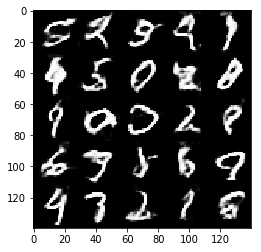

Epoch 2/2, Batch Step:3840, Proc Imgs: 76k ... Discriminator Loss: 1.3770... Generator Loss: 0.8202
Epoch 2/2, Batch Step:4080, Proc Imgs: 81k ... Discriminator Loss: 1.2680... Generator Loss: 0.9612
Epoch 2/2, Batch Step:4320, Proc Imgs: 86k ... Discriminator Loss: 1.2392... Generator Loss: 0.8029
Epoch 2/2, Batch Step:4560, Proc Imgs: 91k ... Discriminator Loss: 1.4444... Generator Loss: 0.8749
Epoch 2/2, Batch Step:4800, Proc Imgs: 96k ... Discriminator Loss: 1.2099... Generator Loss: 0.8054


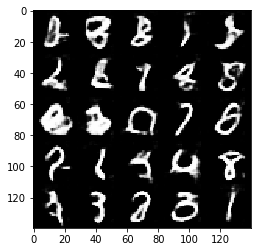

Epoch 2/2, Batch Step:5040, Proc Imgs: 100k ... Discriminator Loss: 1.2331... Generator Loss: 1.0111
Epoch 2/2, Batch Step:5280, Proc Imgs: 105k ... Discriminator Loss: 1.3625... Generator Loss: 0.8832
Epoch 2/2, Batch Step:5520, Proc Imgs: 110k ... Discriminator Loss: 1.2728... Generator Loss: 0.9890
Epoch 2/2, Batch Step:5760, Proc Imgs: 115k ... Discriminator Loss: 1.2141... Generator Loss: 0.7004
Epoch 2/2, Batch Step:6000, Proc Imgs: 120k ... Discriminator Loss: 1.2304... Generator Loss: 0.9953


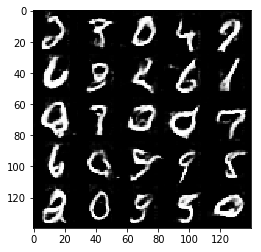

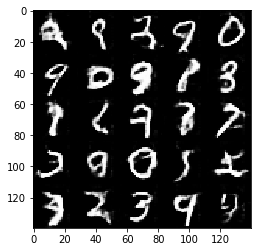

In [13]:
batch_size = 20
z_dim = 100
learning_rate = 2e-4
beta1 = 0.3
alpha = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

input data_shape:  (202599, 28, 28, 3)
input_real: (?, 28, 28, 3), input_z: (?, 100), lr: 0.0002
show status on every 405 batches, image on every 2025 batches
Epoch 1/1, Batch Step:405, Proc Imgs: 8k ... Discriminator Loss: 1.3642... Generator Loss: 0.7014
Epoch 1/1, Batch Step:810, Proc Imgs: 16k ... Discriminator Loss: 1.2851... Generator Loss: 1.0766
Epoch 1/1, Batch Step:1215, Proc Imgs: 24k ... Discriminator Loss: 1.4153... Generator Loss: 0.4801
Epoch 1/1, Batch Step:1620, Proc Imgs: 32k ... Discriminator Loss: 1.1694... Generator Loss: 1.1240
Epoch 1/1, Batch Step:2025, Proc Imgs: 40k ... Discriminator Loss: 0.8895... Generator Loss: 1.4906


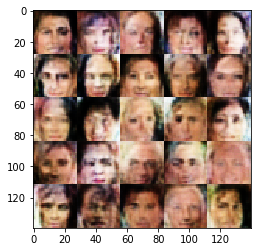

Epoch 1/1, Batch Step:2430, Proc Imgs: 48k ... Discriminator Loss: 1.5019... Generator Loss: 0.4324
Epoch 1/1, Batch Step:2835, Proc Imgs: 56k ... Discriminator Loss: 1.3340... Generator Loss: 0.9859
Epoch 1/1, Batch Step:3240, Proc Imgs: 64k ... Discriminator Loss: 1.3108... Generator Loss: 0.6465
Epoch 1/1, Batch Step:3645, Proc Imgs: 72k ... Discriminator Loss: 1.2500... Generator Loss: 0.8055
Epoch 1/1, Batch Step:4050, Proc Imgs: 81k ... Discriminator Loss: 1.0942... Generator Loss: 1.1784


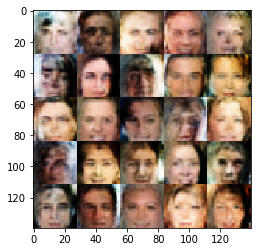

Epoch 1/1, Batch Step:4455, Proc Imgs: 89k ... Discriminator Loss: 1.0347... Generator Loss: 1.1844
Epoch 1/1, Batch Step:4860, Proc Imgs: 97k ... Discriminator Loss: 1.0019... Generator Loss: 1.2769
Epoch 1/1, Batch Step:5265, Proc Imgs: 105k ... Discriminator Loss: 1.2883... Generator Loss: 0.6889
Epoch 1/1, Batch Step:5670, Proc Imgs: 113k ... Discriminator Loss: 1.1858... Generator Loss: 0.7771
Epoch 1/1, Batch Step:6075, Proc Imgs: 121k ... Discriminator Loss: 1.2905... Generator Loss: 0.8373


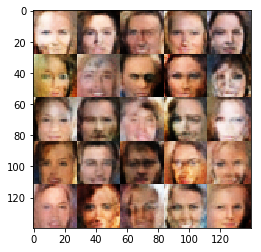

Epoch 1/1, Batch Step:6480, Proc Imgs: 129k ... Discriminator Loss: 1.1924... Generator Loss: 0.9910
Epoch 1/1, Batch Step:6885, Proc Imgs: 137k ... Discriminator Loss: 1.2249... Generator Loss: 0.7299
Epoch 1/1, Batch Step:7290, Proc Imgs: 145k ... Discriminator Loss: 1.4298... Generator Loss: 0.4944
Epoch 1/1, Batch Step:7695, Proc Imgs: 153k ... Discriminator Loss: 1.1914... Generator Loss: 0.7540
Epoch 1/1, Batch Step:8100, Proc Imgs: 162k ... Discriminator Loss: 1.3347... Generator Loss: 0.8503


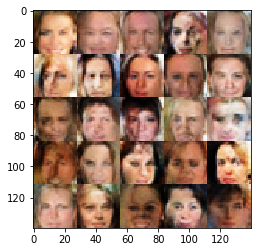

Epoch 1/1, Batch Step:8505, Proc Imgs: 170k ... Discriminator Loss: 1.3192... Generator Loss: 0.7628
Epoch 1/1, Batch Step:8910, Proc Imgs: 178k ... Discriminator Loss: 1.2594... Generator Loss: 0.8097
Epoch 1/1, Batch Step:9315, Proc Imgs: 186k ... Discriminator Loss: 1.2193... Generator Loss: 0.8317
Epoch 1/1, Batch Step:9720, Proc Imgs: 194k ... Discriminator Loss: 1.2489... Generator Loss: 0.8756
Epoch 1/1, Batch Step:10125, Proc Imgs: 202k ... Discriminator Loss: 1.3154... Generator Loss: 0.8490


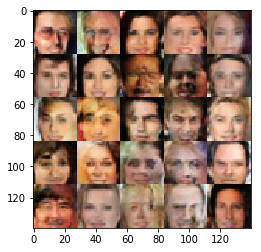

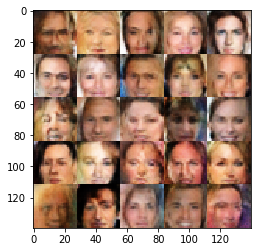

In [14]:
batch_size = 20
z_dim = 100
learning_rate = 2e-4
beta1 = 0.3
alpha = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, alpha)

# LReLU alpha=0.1, Generator (filters 512 -> 64), Beta1=0.1, Batch=100
----

input data_shape:  (60000, 28, 28, 1)
input_real: (?, 28, 28, 1), input_z: (?, 100), lr: 0.0002
show status on every 48 batches, image on every 240 batches
Epoch 1/2, Batch Step:48, Proc Imgs: 4k ... Discriminator Loss: 1.2035... Generator Loss: 0.7232
Epoch 1/2, Batch Step:96, Proc Imgs: 9k ... Discriminator Loss: 1.2940... Generator Loss: 0.5478
Epoch 1/2, Batch Step:144, Proc Imgs: 14k ... Discriminator Loss: 1.3438... Generator Loss: 0.6038
Epoch 1/2, Batch Step:192, Proc Imgs: 19k ... Discriminator Loss: 1.3288... Generator Loss: 0.5950
Epoch 1/2, Batch Step:240, Proc Imgs: 24k ... Discriminator Loss: 1.2919... Generator Loss: 0.6955


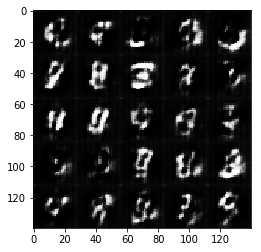

In [ ]:
batch_size = 100
z_dim = 100
learning_rate = 2e-4
beta1 = 0.1
alpha = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha)

input data_shape:  (202599, 28, 28, 3)
input_real: (?, 28, 28, 3), input_z: (?, 100), lr: 0.0002
show status on every 405 batches, image on every 2025 batches
Epoch 1/1, Batch Step:405, Proc Imgs: 8k ... Discriminator Loss: 1.3118... Generator Loss: 0.5819
Epoch 1/1, Batch Step:810, Proc Imgs: 16k ... Discriminator Loss: 1.3718... Generator Loss: 0.6657
Epoch 1/1, Batch Step:1215, Proc Imgs: 24k ... Discriminator Loss: 1.2303... Generator Loss: 0.6212
Epoch 1/1, Batch Step:1620, Proc Imgs: 32k ... Discriminator Loss: 1.0550... Generator Loss: 1.4208
Epoch 1/1, Batch Step:2025, Proc Imgs: 40k ... Discriminator Loss: 1.0518... Generator Loss: 1.6181


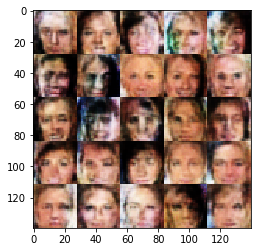

Epoch 1/1, Batch Step:2430, Proc Imgs: 48k ... Discriminator Loss: 1.2606... Generator Loss: 0.7556
Epoch 1/1, Batch Step:2835, Proc Imgs: 56k ... Discriminator Loss: 1.2473... Generator Loss: 0.7161
Epoch 1/1, Batch Step:3240, Proc Imgs: 64k ... Discriminator Loss: 1.2359... Generator Loss: 0.6255
Epoch 1/1, Batch Step:3645, Proc Imgs: 72k ... Discriminator Loss: 1.2500... Generator Loss: 0.8030
Epoch 1/1, Batch Step:4050, Proc Imgs: 81k ... Discriminator Loss: 1.3477... Generator Loss: 0.7346


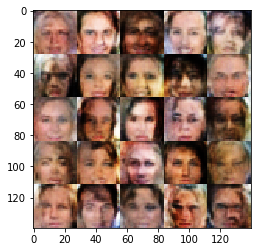

Epoch 1/1, Batch Step:4455, Proc Imgs: 89k ... Discriminator Loss: 1.2939... Generator Loss: 0.8855
Epoch 1/1, Batch Step:4860, Proc Imgs: 97k ... Discriminator Loss: 1.2333... Generator Loss: 0.8001
Epoch 1/1, Batch Step:5265, Proc Imgs: 105k ... Discriminator Loss: 1.2729... Generator Loss: 0.6446
Epoch 1/1, Batch Step:5670, Proc Imgs: 113k ... Discriminator Loss: 1.1719... Generator Loss: 0.8663
Epoch 1/1, Batch Step:6075, Proc Imgs: 121k ... Discriminator Loss: 1.3293... Generator Loss: 0.8093


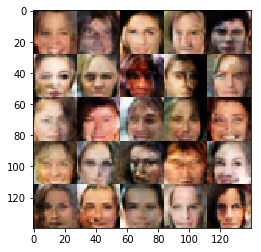

Epoch 1/1, Batch Step:6480, Proc Imgs: 129k ... Discriminator Loss: 1.3508... Generator Loss: 0.9536
Epoch 1/1, Batch Step:6885, Proc Imgs: 137k ... Discriminator Loss: 1.4648... Generator Loss: 0.5052
Epoch 1/1, Batch Step:7290, Proc Imgs: 145k ... Discriminator Loss: 1.3713... Generator Loss: 0.7914
Epoch 1/1, Batch Step:7695, Proc Imgs: 153k ... Discriminator Loss: 1.3854... Generator Loss: 0.6040
Epoch 1/1, Batch Step:8100, Proc Imgs: 162k ... Discriminator Loss: 1.3134... Generator Loss: 0.7887


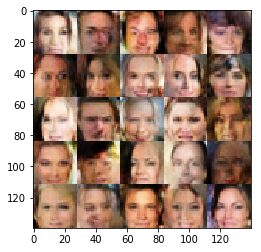

Epoch 1/1, Batch Step:8505, Proc Imgs: 170k ... Discriminator Loss: 1.2674... Generator Loss: 0.7132
Epoch 1/1, Batch Step:8910, Proc Imgs: 178k ... Discriminator Loss: 1.2028... Generator Loss: 0.7061
Epoch 1/1, Batch Step:9315, Proc Imgs: 186k ... Discriminator Loss: 1.1792... Generator Loss: 0.9901
Epoch 1/1, Batch Step:9720, Proc Imgs: 194k ... Discriminator Loss: 1.2513... Generator Loss: 0.7796
Epoch 1/1, Batch Step:10125, Proc Imgs: 202k ... Discriminator Loss: 1.3097... Generator Loss: 0.6887


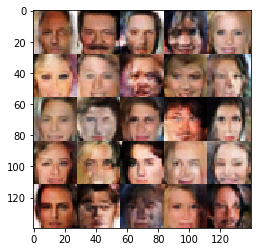

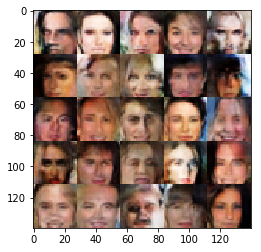

In [17]:
batch_size = 20
z_dim = 100
learning_rate = 2e-4
beta1 = 0.1
alpha = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, alpha)

# LReLU alpha=0.1, Generator (filters 512 -> 64), Beta1=0.1, Batch=100, More Epochs
----

input data_shape:  (60000, 28, 28, 1)
input_real: (?, 28, 28, 1), input_z: (?, 100), lr: 0.0002
show status on every 60 batches, image on every 300 batches
Epoch 1/10, Batch Step:60, Proc Imgs: 6k ... Discriminator Loss: 1.3149... Generator Loss: 0.5394
Epoch 1/10, Batch Step:120, Proc Imgs: 12k ... Discriminator Loss: 1.3344... Generator Loss: 0.6034
Epoch 1/10, Batch Step:180, Proc Imgs: 18k ... Discriminator Loss: 1.3333... Generator Loss: 0.6981
Epoch 1/10, Batch Step:240, Proc Imgs: 24k ... Discriminator Loss: 1.3481... Generator Loss: 0.5527
Epoch 1/10, Batch Step:300, Proc Imgs: 30k ... Discriminator Loss: 1.3604... Generator Loss: 0.8689


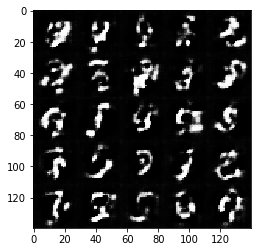

Epoch 1/10, Batch Step:360, Proc Imgs: 36k ... Discriminator Loss: 1.3644... Generator Loss: 0.9708
Epoch 1/10, Batch Step:420, Proc Imgs: 42k ... Discriminator Loss: 1.3334... Generator Loss: 0.7428
Epoch 1/10, Batch Step:480, Proc Imgs: 48k ... Discriminator Loss: 1.3515... Generator Loss: 1.0345
Epoch 1/10, Batch Step:540, Proc Imgs: 54k ... Discriminator Loss: 1.3315... Generator Loss: 0.9152
Epoch 1/10, Batch Step:600, Proc Imgs: 60k ... Discriminator Loss: 1.3615... Generator Loss: 0.9418


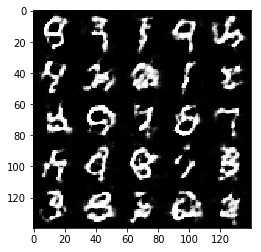

Epoch 2/10, Batch Step:660, Proc Imgs: 66k ... Discriminator Loss: 1.3410... Generator Loss: 0.6274
Epoch 2/10, Batch Step:720, Proc Imgs: 72k ... Discriminator Loss: 1.3634... Generator Loss: 0.6334
Epoch 2/10, Batch Step:780, Proc Imgs: 78k ... Discriminator Loss: 1.3610... Generator Loss: 0.8044
Epoch 2/10, Batch Step:840, Proc Imgs: 84k ... Discriminator Loss: 1.3407... Generator Loss: 0.6922
Epoch 2/10, Batch Step:900, Proc Imgs: 90k ... Discriminator Loss: 1.3378... Generator Loss: 0.8162


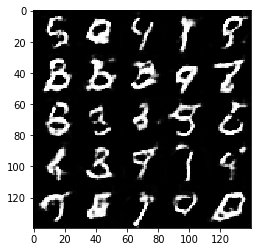

Epoch 2/10, Batch Step:960, Proc Imgs: 96k ... Discriminator Loss: 1.3691... Generator Loss: 0.7233
Epoch 2/10, Batch Step:1020, Proc Imgs: 102k ... Discriminator Loss: 1.3624... Generator Loss: 0.6344
Epoch 2/10, Batch Step:1080, Proc Imgs: 108k ... Discriminator Loss: 1.3597... Generator Loss: 0.6945
Epoch 2/10, Batch Step:1140, Proc Imgs: 114k ... Discriminator Loss: 1.3369... Generator Loss: 0.7652
Epoch 2/10, Batch Step:1200, Proc Imgs: 120k ... Discriminator Loss: 1.3620... Generator Loss: 0.8009


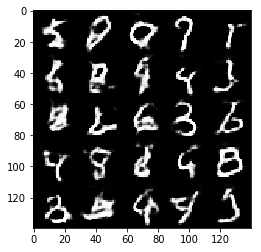

Epoch 3/10, Batch Step:1260, Proc Imgs: 126k ... Discriminator Loss: 1.3515... Generator Loss: 0.8351
Epoch 3/10, Batch Step:1320, Proc Imgs: 132k ... Discriminator Loss: 1.3647... Generator Loss: 0.8429
Epoch 3/10, Batch Step:1380, Proc Imgs: 138k ... Discriminator Loss: 1.3151... Generator Loss: 0.8364
Epoch 3/10, Batch Step:1440, Proc Imgs: 144k ... Discriminator Loss: 1.3403... Generator Loss: 0.7021
Epoch 3/10, Batch Step:1500, Proc Imgs: 150k ... Discriminator Loss: 1.3379... Generator Loss: 0.7811


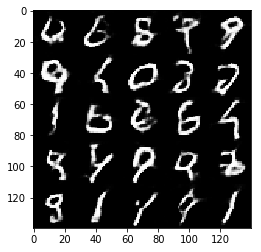

Epoch 3/10, Batch Step:1560, Proc Imgs: 156k ... Discriminator Loss: 1.3902... Generator Loss: 0.7274
Epoch 3/10, Batch Step:1620, Proc Imgs: 162k ... Discriminator Loss: 1.3685... Generator Loss: 0.6541
Epoch 3/10, Batch Step:1680, Proc Imgs: 168k ... Discriminator Loss: 1.3490... Generator Loss: 0.8432
Epoch 3/10, Batch Step:1740, Proc Imgs: 174k ... Discriminator Loss: 1.3529... Generator Loss: 0.6587
Epoch 3/10, Batch Step:1800, Proc Imgs: 180k ... Discriminator Loss: 1.3217... Generator Loss: 0.8384


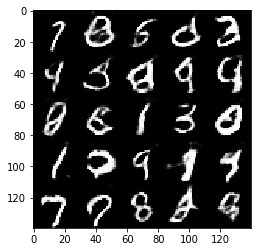

Epoch 4/10, Batch Step:1860, Proc Imgs: 186k ... Discriminator Loss: 1.3314... Generator Loss: 0.8071
Epoch 4/10, Batch Step:1920, Proc Imgs: 192k ... Discriminator Loss: 1.3531... Generator Loss: 0.8464
Epoch 4/10, Batch Step:1980, Proc Imgs: 198k ... Discriminator Loss: 1.3090... Generator Loss: 0.7441
Epoch 4/10, Batch Step:2040, Proc Imgs: 204k ... Discriminator Loss: 1.3500... Generator Loss: 0.7870
Epoch 4/10, Batch Step:2100, Proc Imgs: 210k ... Discriminator Loss: 1.3440... Generator Loss: 0.8100


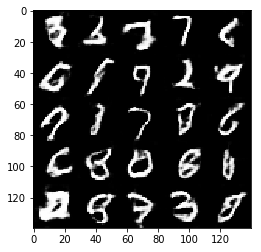

Epoch 4/10, Batch Step:2160, Proc Imgs: 216k ... Discriminator Loss: 1.3402... Generator Loss: 0.7219
Epoch 4/10, Batch Step:2220, Proc Imgs: 222k ... Discriminator Loss: 1.3383... Generator Loss: 0.6939
Epoch 4/10, Batch Step:2280, Proc Imgs: 228k ... Discriminator Loss: 1.3153... Generator Loss: 0.7823
Epoch 4/10, Batch Step:2340, Proc Imgs: 234k ... Discriminator Loss: 1.3716... Generator Loss: 0.6666
Epoch 4/10, Batch Step:2400, Proc Imgs: 240k ... Discriminator Loss: 1.3369... Generator Loss: 0.7632


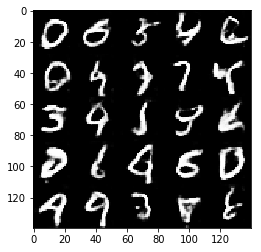

Epoch 5/10, Batch Step:2460, Proc Imgs: 246k ... Discriminator Loss: 1.3492... Generator Loss: 0.7732
Epoch 5/10, Batch Step:2520, Proc Imgs: 252k ... Discriminator Loss: 1.3399... Generator Loss: 0.8074
Epoch 5/10, Batch Step:2580, Proc Imgs: 258k ... Discriminator Loss: 1.3214... Generator Loss: 0.7210
Epoch 5/10, Batch Step:2640, Proc Imgs: 264k ... Discriminator Loss: 1.4056... Generator Loss: 0.5934
Epoch 5/10, Batch Step:2700, Proc Imgs: 270k ... Discriminator Loss: 1.3064... Generator Loss: 0.9287


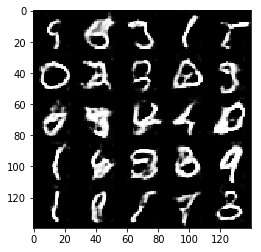

Epoch 5/10, Batch Step:2760, Proc Imgs: 276k ... Discriminator Loss: 1.3204... Generator Loss: 0.7244
Epoch 5/10, Batch Step:2820, Proc Imgs: 282k ... Discriminator Loss: 1.3827... Generator Loss: 0.6601
Epoch 5/10, Batch Step:2880, Proc Imgs: 288k ... Discriminator Loss: 1.2864... Generator Loss: 0.7929
Epoch 5/10, Batch Step:2940, Proc Imgs: 294k ... Discriminator Loss: 1.3317... Generator Loss: 0.8372
Epoch 5/10, Batch Step:3000, Proc Imgs: 300k ... Discriminator Loss: 1.3426... Generator Loss: 0.7362


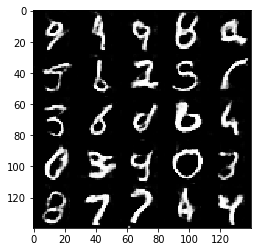

Epoch 6/10, Batch Step:3060, Proc Imgs: 306k ... Discriminator Loss: 1.3204... Generator Loss: 0.7038
Epoch 6/10, Batch Step:3120, Proc Imgs: 312k ... Discriminator Loss: 1.3600... Generator Loss: 0.5993
Epoch 6/10, Batch Step:3180, Proc Imgs: 318k ... Discriminator Loss: 1.2991... Generator Loss: 0.7255
Epoch 6/10, Batch Step:3240, Proc Imgs: 324k ... Discriminator Loss: 1.3138... Generator Loss: 0.7843
Epoch 6/10, Batch Step:3300, Proc Imgs: 330k ... Discriminator Loss: 1.3303... Generator Loss: 0.6655


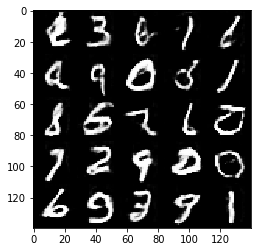

Epoch 6/10, Batch Step:3360, Proc Imgs: 336k ... Discriminator Loss: 1.3498... Generator Loss: 0.7115
Epoch 6/10, Batch Step:3420, Proc Imgs: 342k ... Discriminator Loss: 1.3533... Generator Loss: 0.7630
Epoch 6/10, Batch Step:3480, Proc Imgs: 348k ... Discriminator Loss: 1.3034... Generator Loss: 0.6819
Epoch 6/10, Batch Step:3540, Proc Imgs: 354k ... Discriminator Loss: 1.3893... Generator Loss: 0.7337
Epoch 6/10, Batch Step:3600, Proc Imgs: 360k ... Discriminator Loss: 1.3489... Generator Loss: 0.6727


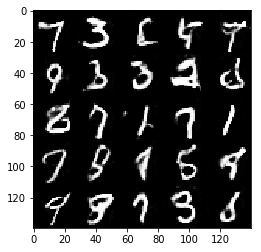

Epoch 7/10, Batch Step:3660, Proc Imgs: 366k ... Discriminator Loss: 1.2977... Generator Loss: 0.7712
Epoch 7/10, Batch Step:3720, Proc Imgs: 372k ... Discriminator Loss: 1.3106... Generator Loss: 0.7517
Epoch 7/10, Batch Step:3780, Proc Imgs: 378k ... Discriminator Loss: 1.3143... Generator Loss: 0.8023
Epoch 7/10, Batch Step:3840, Proc Imgs: 384k ... Discriminator Loss: 1.3751... Generator Loss: 0.7051
Epoch 7/10, Batch Step:3900, Proc Imgs: 390k ... Discriminator Loss: 1.2883... Generator Loss: 0.7874


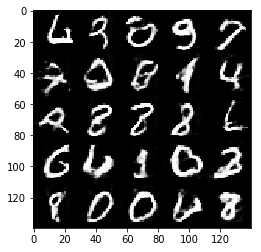

Epoch 7/10, Batch Step:3960, Proc Imgs: 396k ... Discriminator Loss: 1.3316... Generator Loss: 0.7689
Epoch 7/10, Batch Step:4020, Proc Imgs: 402k ... Discriminator Loss: 1.3491... Generator Loss: 0.6417
Epoch 7/10, Batch Step:4080, Proc Imgs: 408k ... Discriminator Loss: 1.3802... Generator Loss: 0.8354
Epoch 7/10, Batch Step:4140, Proc Imgs: 414k ... Discriminator Loss: 1.3583... Generator Loss: 0.8467
Epoch 7/10, Batch Step:4200, Proc Imgs: 420k ... Discriminator Loss: 1.3032... Generator Loss: 0.8875


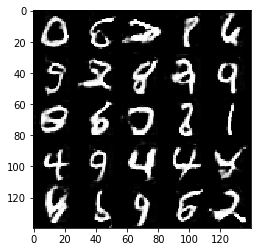

Epoch 8/10, Batch Step:4260, Proc Imgs: 426k ... Discriminator Loss: 1.3167... Generator Loss: 0.8628
Epoch 8/10, Batch Step:4320, Proc Imgs: 432k ... Discriminator Loss: 1.3322... Generator Loss: 0.7454
Epoch 8/10, Batch Step:4380, Proc Imgs: 438k ... Discriminator Loss: 1.3112... Generator Loss: 0.9021
Epoch 8/10, Batch Step:4440, Proc Imgs: 444k ... Discriminator Loss: 1.3684... Generator Loss: 0.7168
Epoch 8/10, Batch Step:4500, Proc Imgs: 450k ... Discriminator Loss: 1.3153... Generator Loss: 0.7423


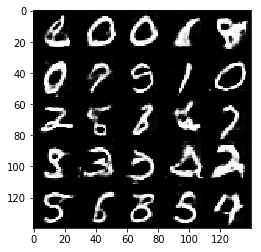

Epoch 8/10, Batch Step:4560, Proc Imgs: 456k ... Discriminator Loss: 1.3397... Generator Loss: 0.7286
Epoch 8/10, Batch Step:4620, Proc Imgs: 462k ... Discriminator Loss: 1.3407... Generator Loss: 0.7851
Epoch 8/10, Batch Step:4680, Proc Imgs: 468k ... Discriminator Loss: 1.3259... Generator Loss: 0.7579
Epoch 8/10, Batch Step:4740, Proc Imgs: 474k ... Discriminator Loss: 1.3495... Generator Loss: 0.9351
Epoch 8/10, Batch Step:4800, Proc Imgs: 480k ... Discriminator Loss: 1.3095... Generator Loss: 0.7717


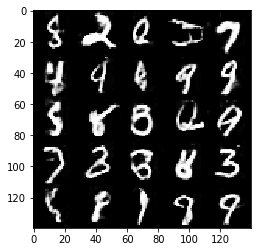

Epoch 9/10, Batch Step:4860, Proc Imgs: 486k ... Discriminator Loss: 1.3355... Generator Loss: 0.6763
Epoch 9/10, Batch Step:4920, Proc Imgs: 492k ... Discriminator Loss: 1.3314... Generator Loss: 0.7798
Epoch 9/10, Batch Step:4980, Proc Imgs: 498k ... Discriminator Loss: 1.2968... Generator Loss: 0.7800
Epoch 9/10, Batch Step:5040, Proc Imgs: 504k ... Discriminator Loss: 1.3633... Generator Loss: 0.6422
Epoch 9/10, Batch Step:5100, Proc Imgs: 510k ... Discriminator Loss: 1.3121... Generator Loss: 0.7122


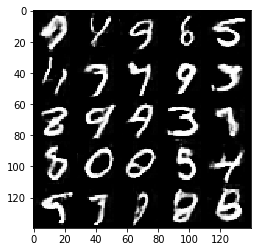

Epoch 9/10, Batch Step:5160, Proc Imgs: 516k ... Discriminator Loss: 1.3561... Generator Loss: 0.7222
Epoch 9/10, Batch Step:5220, Proc Imgs: 522k ... Discriminator Loss: 1.3593... Generator Loss: 0.8000
Epoch 9/10, Batch Step:5280, Proc Imgs: 528k ... Discriminator Loss: 1.3375... Generator Loss: 0.6401
Epoch 9/10, Batch Step:5340, Proc Imgs: 534k ... Discriminator Loss: 1.3110... Generator Loss: 0.7480
Epoch 9/10, Batch Step:5400, Proc Imgs: 540k ... Discriminator Loss: 1.3160... Generator Loss: 0.7586


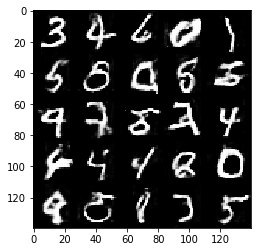

Epoch 10/10, Batch Step:5460, Proc Imgs: 546k ... Discriminator Loss: 1.3263... Generator Loss: 0.7837
Epoch 10/10, Batch Step:5520, Proc Imgs: 552k ... Discriminator Loss: 1.3244... Generator Loss: 0.7168
Epoch 10/10, Batch Step:5580, Proc Imgs: 558k ... Discriminator Loss: 1.2957... Generator Loss: 0.7379
Epoch 10/10, Batch Step:5640, Proc Imgs: 564k ... Discriminator Loss: 1.3204... Generator Loss: 0.7684
Epoch 10/10, Batch Step:5700, Proc Imgs: 570k ... Discriminator Loss: 1.3036... Generator Loss: 0.8436


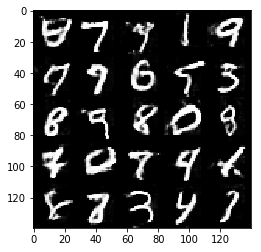

Epoch 10/10, Batch Step:5760, Proc Imgs: 576k ... Discriminator Loss: 1.3667... Generator Loss: 0.7874
Epoch 10/10, Batch Step:5820, Proc Imgs: 582k ... Discriminator Loss: 1.3226... Generator Loss: 0.8518
Epoch 10/10, Batch Step:5880, Proc Imgs: 588k ... Discriminator Loss: 1.3384... Generator Loss: 0.7462
Epoch 10/10, Batch Step:5940, Proc Imgs: 594k ... Discriminator Loss: 1.3524... Generator Loss: 0.6796
Epoch 10/10, Batch Step:6000, Proc Imgs: 600k ... Discriminator Loss: 1.3409... Generator Loss: 0.9150


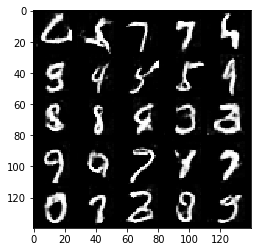

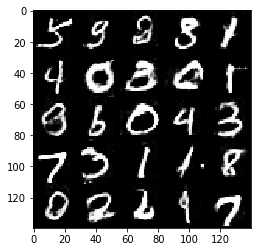

In [19]:
batch_size = 100
z_dim = 100
learning_rate = 2e-4
beta1 = 0.1
alpha = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha, 100)

input data_shape:  (202599, 28, 28, 3)
input_real: (?, 28, 28, 3), input_z: (?, 100), lr: 0.0002
show status on every 1012 batches, image on every 5064 batches
Epoch 1/10, Batch Step:1012, Proc Imgs: 20k ... Discriminator Loss: 1.1917... Generator Loss: 0.8098
Epoch 1/10, Batch Step:2024, Proc Imgs: 40k ... Discriminator Loss: 1.2018... Generator Loss: 0.6545
Epoch 1/10, Batch Step:3036, Proc Imgs: 60k ... Discriminator Loss: 1.1530... Generator Loss: 0.8969
Epoch 1/10, Batch Step:4048, Proc Imgs: 80k ... Discriminator Loss: 1.2913... Generator Loss: 0.8301
Epoch 1/10, Batch Step:5060, Proc Imgs: 101k ... Discriminator Loss: 1.2844... Generator Loss: 0.6624


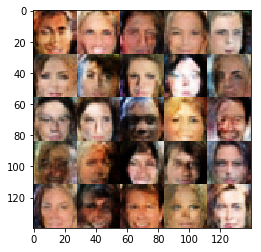

Epoch 1/10, Batch Step:6072, Proc Imgs: 121k ... Discriminator Loss: 1.3579... Generator Loss: 0.7260
Epoch 1/10, Batch Step:7084, Proc Imgs: 141k ... Discriminator Loss: 1.3133... Generator Loss: 1.0722
Epoch 1/10, Batch Step:8096, Proc Imgs: 161k ... Discriminator Loss: 1.2671... Generator Loss: 0.6663
Epoch 1/10, Batch Step:9108, Proc Imgs: 182k ... Discriminator Loss: 1.3056... Generator Loss: 0.7173
Epoch 1/10, Batch Step:10120, Proc Imgs: 202k ... Discriminator Loss: 1.2449... Generator Loss: 0.6858


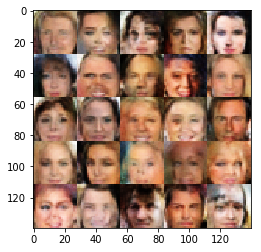

Epoch 2/10, Batch Step:11132, Proc Imgs: 222k ... Discriminator Loss: 1.3731... Generator Loss: 0.9780
Epoch 2/10, Batch Step:12144, Proc Imgs: 242k ... Discriminator Loss: 1.3613... Generator Loss: 0.6779
Epoch 2/10, Batch Step:13156, Proc Imgs: 263k ... Discriminator Loss: 1.2646... Generator Loss: 0.7334
Epoch 2/10, Batch Step:14168, Proc Imgs: 283k ... Discriminator Loss: 1.2660... Generator Loss: 0.7633
Epoch 2/10, Batch Step:15180, Proc Imgs: 303k ... Discriminator Loss: 1.2993... Generator Loss: 0.6530


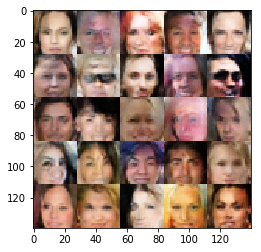

Epoch 2/10, Batch Step:16192, Proc Imgs: 323k ... Discriminator Loss: 1.2806... Generator Loss: 0.8044
Epoch 2/10, Batch Step:17204, Proc Imgs: 344k ... Discriminator Loss: 1.3587... Generator Loss: 0.7085
Epoch 2/10, Batch Step:18216, Proc Imgs: 364k ... Discriminator Loss: 1.3058... Generator Loss: 0.8041
Epoch 2/10, Batch Step:19228, Proc Imgs: 384k ... Discriminator Loss: 1.2644... Generator Loss: 0.7714
Epoch 2/10, Batch Step:20240, Proc Imgs: 404k ... Discriminator Loss: 1.3157... Generator Loss: 0.6994


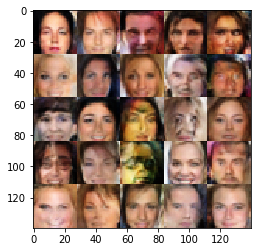

Epoch 3/10, Batch Step:21252, Proc Imgs: 425k ... Discriminator Loss: 1.3402... Generator Loss: 0.8723
Epoch 3/10, Batch Step:22264, Proc Imgs: 445k ... Discriminator Loss: 1.2909... Generator Loss: 0.7135
Epoch 3/10, Batch Step:23276, Proc Imgs: 465k ... Discriminator Loss: 1.2726... Generator Loss: 0.6850
Epoch 3/10, Batch Step:24288, Proc Imgs: 485k ... Discriminator Loss: 1.2790... Generator Loss: 0.6870
Epoch 3/10, Batch Step:25300, Proc Imgs: 506k ... Discriminator Loss: 1.3582... Generator Loss: 0.7567


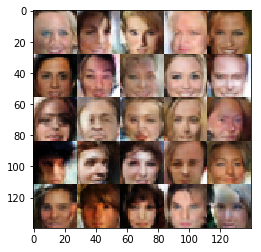

Epoch 3/10, Batch Step:26312, Proc Imgs: 526k ... Discriminator Loss: 1.3442... Generator Loss: 0.7534
Epoch 3/10, Batch Step:27324, Proc Imgs: 546k ... Discriminator Loss: 1.3329... Generator Loss: 0.7184
Epoch 3/10, Batch Step:28336, Proc Imgs: 566k ... Discriminator Loss: 1.3440... Generator Loss: 0.7715
Epoch 3/10, Batch Step:29348, Proc Imgs: 586k ... Discriminator Loss: 1.2744... Generator Loss: 0.6567
Epoch 3/10, Batch Step:30360, Proc Imgs: 607k ... Discriminator Loss: 1.3478... Generator Loss: 0.7510


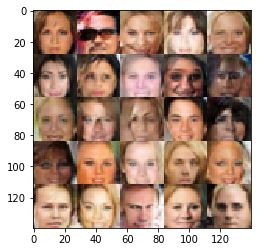

Epoch 4/10, Batch Step:31372, Proc Imgs: 627k ... Discriminator Loss: 1.3785... Generator Loss: 0.6312
Epoch 4/10, Batch Step:32384, Proc Imgs: 647k ... Discriminator Loss: 1.3379... Generator Loss: 0.7673
Epoch 4/10, Batch Step:33396, Proc Imgs: 667k ... Discriminator Loss: 1.3282... Generator Loss: 0.8063
Epoch 4/10, Batch Step:34408, Proc Imgs: 688k ... Discriminator Loss: 1.3254... Generator Loss: 0.8521
Epoch 4/10, Batch Step:35420, Proc Imgs: 708k ... Discriminator Loss: 1.3759... Generator Loss: 0.7581


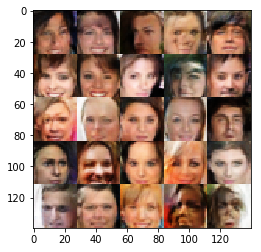

Epoch 4/10, Batch Step:36432, Proc Imgs: 728k ... Discriminator Loss: 1.3716... Generator Loss: 0.6480
Epoch 4/10, Batch Step:37444, Proc Imgs: 748k ... Discriminator Loss: 1.3230... Generator Loss: 0.7434
Epoch 4/10, Batch Step:38456, Proc Imgs: 769k ... Discriminator Loss: 1.3066... Generator Loss: 0.6873
Epoch 4/10, Batch Step:39468, Proc Imgs: 789k ... Discriminator Loss: 1.3837... Generator Loss: 0.6918
Epoch 4/10, Batch Step:40480, Proc Imgs: 809k ... Discriminator Loss: 1.3004... Generator Loss: 0.7094


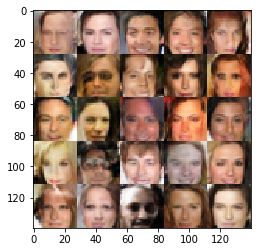

Epoch 5/10, Batch Step:41492, Proc Imgs: 829k ... Discriminator Loss: 1.2565... Generator Loss: 0.7544
Epoch 5/10, Batch Step:42504, Proc Imgs: 850k ... Discriminator Loss: 1.3192... Generator Loss: 0.8558
Epoch 5/10, Batch Step:43516, Proc Imgs: 870k ... Discriminator Loss: 1.3387... Generator Loss: 0.8592
Epoch 5/10, Batch Step:44528, Proc Imgs: 890k ... Discriminator Loss: 1.3517... Generator Loss: 0.7191
Epoch 5/10, Batch Step:45540, Proc Imgs: 910k ... Discriminator Loss: 1.3042... Generator Loss: 0.7294


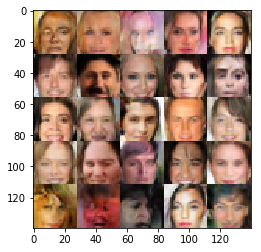

Epoch 5/10, Batch Step:46552, Proc Imgs: 931k ... Discriminator Loss: 1.4000... Generator Loss: 0.7823
Epoch 5/10, Batch Step:47564, Proc Imgs: 951k ... Discriminator Loss: 1.3609... Generator Loss: 0.6160
Epoch 5/10, Batch Step:48576, Proc Imgs: 971k ... Discriminator Loss: 1.3933... Generator Loss: 0.7601
Epoch 5/10, Batch Step:49588, Proc Imgs: 991k ... Discriminator Loss: 1.3425... Generator Loss: 0.7401
Epoch 5/10, Batch Step:50600, Proc Imgs: 1012k ... Discriminator Loss: 1.3073... Generator Loss: 0.7891


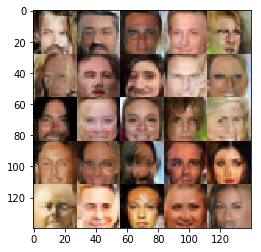

Epoch 6/10, Batch Step:51612, Proc Imgs: 1032k ... Discriminator Loss: 1.2521... Generator Loss: 0.9693
Epoch 6/10, Batch Step:52624, Proc Imgs: 1052k ... Discriminator Loss: 1.3653... Generator Loss: 0.6357
Epoch 6/10, Batch Step:53636, Proc Imgs: 1072k ... Discriminator Loss: 1.3454... Generator Loss: 0.7474
Epoch 6/10, Batch Step:54648, Proc Imgs: 1092k ... Discriminator Loss: 1.3003... Generator Loss: 0.6597
Epoch 6/10, Batch Step:55660, Proc Imgs: 1113k ... Discriminator Loss: 1.3069... Generator Loss: 0.9840


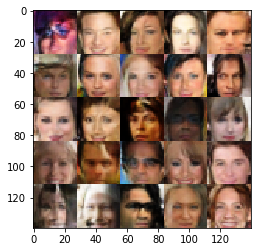

Epoch 6/10, Batch Step:56672, Proc Imgs: 1133k ... Discriminator Loss: 1.2919... Generator Loss: 0.8492
Epoch 6/10, Batch Step:57684, Proc Imgs: 1153k ... Discriminator Loss: 1.2863... Generator Loss: 0.7454
Epoch 6/10, Batch Step:58696, Proc Imgs: 1173k ... Discriminator Loss: 1.2499... Generator Loss: 0.8039
Epoch 6/10, Batch Step:59708, Proc Imgs: 1194k ... Discriminator Loss: 1.4444... Generator Loss: 0.8140
Epoch 6/10, Batch Step:60720, Proc Imgs: 1214k ... Discriminator Loss: 1.3255... Generator Loss: 0.9354


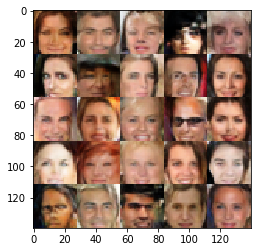

Epoch 7/10, Batch Step:61732, Proc Imgs: 1234k ... Discriminator Loss: 1.3445... Generator Loss: 0.7526
Epoch 7/10, Batch Step:62744, Proc Imgs: 1254k ... Discriminator Loss: 1.3446... Generator Loss: 0.7028
Epoch 7/10, Batch Step:63756, Proc Imgs: 1275k ... Discriminator Loss: 1.2543... Generator Loss: 0.8110
Epoch 7/10, Batch Step:64768, Proc Imgs: 1295k ... Discriminator Loss: 1.3530... Generator Loss: 0.6910
Epoch 7/10, Batch Step:65780, Proc Imgs: 1315k ... Discriminator Loss: 1.2261... Generator Loss: 0.8113


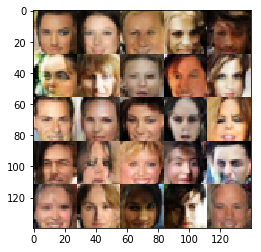

Epoch 7/10, Batch Step:66792, Proc Imgs: 1335k ... Discriminator Loss: 1.3730... Generator Loss: 0.7302
Epoch 7/10, Batch Step:67804, Proc Imgs: 1356k ... Discriminator Loss: 1.4001... Generator Loss: 0.7079
Epoch 7/10, Batch Step:68816, Proc Imgs: 1376k ... Discriminator Loss: 1.3432... Generator Loss: 0.7123
Epoch 7/10, Batch Step:69828, Proc Imgs: 1396k ... Discriminator Loss: 1.3577... Generator Loss: 0.8215
Epoch 7/10, Batch Step:70840, Proc Imgs: 1416k ... Discriminator Loss: 1.2300... Generator Loss: 0.6770


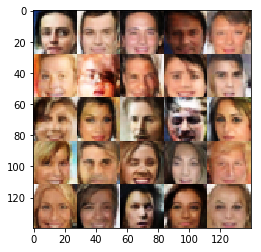

Epoch 8/10, Batch Step:71852, Proc Imgs: 1437k ... Discriminator Loss: 1.3008... Generator Loss: 0.7947
Epoch 8/10, Batch Step:72864, Proc Imgs: 1457k ... Discriminator Loss: 1.3598... Generator Loss: 0.8313
Epoch 8/10, Batch Step:73876, Proc Imgs: 1477k ... Discriminator Loss: 1.3454... Generator Loss: 0.7379
Epoch 8/10, Batch Step:74888, Proc Imgs: 1497k ... Discriminator Loss: 1.2872... Generator Loss: 0.6344
Epoch 8/10, Batch Step:75900, Proc Imgs: 1518k ... Discriminator Loss: 1.2947... Generator Loss: 1.0574


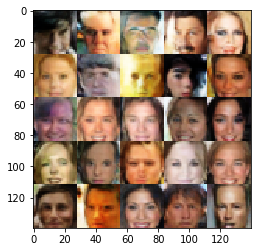

Epoch 8/10, Batch Step:76912, Proc Imgs: 1538k ... Discriminator Loss: 1.3905... Generator Loss: 0.8917
Epoch 8/10, Batch Step:77924, Proc Imgs: 1558k ... Discriminator Loss: 1.2632... Generator Loss: 0.6463
Epoch 8/10, Batch Step:78936, Proc Imgs: 1578k ... Discriminator Loss: 1.2026... Generator Loss: 0.7001
Epoch 8/10, Batch Step:79948, Proc Imgs: 1598k ... Discriminator Loss: 1.3205... Generator Loss: 0.6738
Epoch 8/10, Batch Step:80960, Proc Imgs: 1619k ... Discriminator Loss: 1.2950... Generator Loss: 0.6243


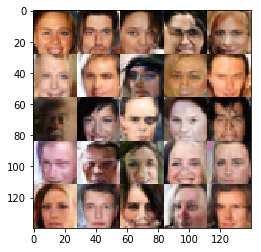

Epoch 9/10, Batch Step:81972, Proc Imgs: 1639k ... Discriminator Loss: 1.3304... Generator Loss: 0.7700
Epoch 9/10, Batch Step:82984, Proc Imgs: 1659k ... Discriminator Loss: 1.2866... Generator Loss: 0.7256
Epoch 9/10, Batch Step:83996, Proc Imgs: 1679k ... Discriminator Loss: 1.3668... Generator Loss: 0.8778
Epoch 9/10, Batch Step:85008, Proc Imgs: 1700k ... Discriminator Loss: 1.3643... Generator Loss: 0.6232
Epoch 9/10, Batch Step:86020, Proc Imgs: 1720k ... Discriminator Loss: 1.2312... Generator Loss: 0.7706


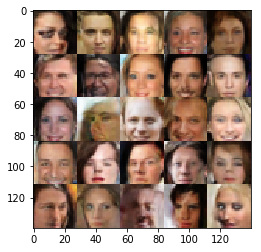

Epoch 9/10, Batch Step:87032, Proc Imgs: 1740k ... Discriminator Loss: 1.2731... Generator Loss: 0.7173
Epoch 9/10, Batch Step:88044, Proc Imgs: 1760k ... Discriminator Loss: 1.2368... Generator Loss: 0.8693
Epoch 9/10, Batch Step:89056, Proc Imgs: 1781k ... Discriminator Loss: 1.3147... Generator Loss: 0.7658
Epoch 9/10, Batch Step:90068, Proc Imgs: 1801k ... Discriminator Loss: 1.3008... Generator Loss: 0.8200
Epoch 9/10, Batch Step:91080, Proc Imgs: 1821k ... Discriminator Loss: 1.3402... Generator Loss: 0.8408


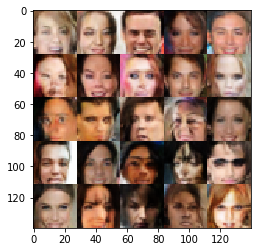

Epoch 10/10, Batch Step:92092, Proc Imgs: 1841k ... Discriminator Loss: 1.3188... Generator Loss: 0.7370
Epoch 10/10, Batch Step:93104, Proc Imgs: 1862k ... Discriminator Loss: 1.3368... Generator Loss: 0.8997
Epoch 10/10, Batch Step:94116, Proc Imgs: 1882k ... Discriminator Loss: 1.3863... Generator Loss: 0.7017
Epoch 10/10, Batch Step:95128, Proc Imgs: 1902k ... Discriminator Loss: 1.3298... Generator Loss: 0.9599
Epoch 10/10, Batch Step:96140, Proc Imgs: 1922k ... Discriminator Loss: 1.1799... Generator Loss: 0.8023


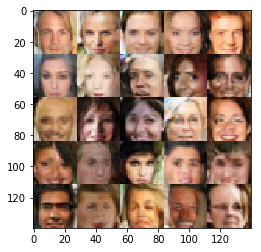

Epoch 10/10, Batch Step:97152, Proc Imgs: 1943k ... Discriminator Loss: 1.2447... Generator Loss: 0.8392
Epoch 10/10, Batch Step:98164, Proc Imgs: 1963k ... Discriminator Loss: 1.2806... Generator Loss: 0.8983
Epoch 10/10, Batch Step:99176, Proc Imgs: 1983k ... Discriminator Loss: 1.1991... Generator Loss: 0.7285
Epoch 10/10, Batch Step:100188, Proc Imgs: 2003k ... Discriminator Loss: 1.3884... Generator Loss: 0.6924
Epoch 10/10, Batch Step:101200, Proc Imgs: 2024k ... Discriminator Loss: 1.2118... Generator Loss: 0.8612


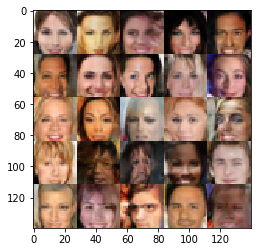

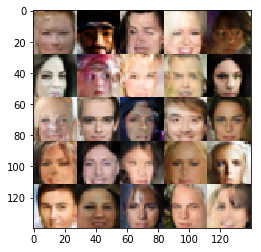

In [20]:
batch_size = 20
z_dim = 100
learning_rate = 2e-4
beta1 = 0.1
alpha = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, alpha, 100)